# Proyecto - *Data Product Architecture* (Primavera 2021)
## *Chicago Food Inspections*
## Maestría en Ciencia de Datos, ITAM
### M. Sc. Liliana Millán Núñez
### *Checkpoint* 4: *Feature Engineering*
#### Equipo 5
---

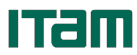

In [1]:
from IPython.display import Image
Image("itam_logo.png")

---

Integrante | Alumno                         | Clave única
---------- | ------------------------------ | -----------
1          | Carlos Román López Sierra      | 197911
2          | José Luis Zárate Cortés        | 183347
3          | Octavio Fuentes Ortiz          | 150792
4          | Patricia Urriza Arellano       | 152026
5          | Uriel Abraham Rangel Díaz      | 193921

Jueves 8 de abril de 2021

---

**¿Qué pregunta analítica buscamos contestar con nuestro modelo?** 

Buscamos contestar si el establecimiento pasará o no pasará la inspección.

---

Los paquetes que utilizamos son:
- [***numpy***](https://numpy.org/)
- [***pandas***](https://pandas.pydata.org/)
- [***geopandas***](https://geopandas.org/)
- [***shapely***](https://pypi.org/project/Shapely/)
- [***datetime***](https://docs.python.org/3/library/datetime.html)
- [***csv***](https://docs.python.org/3/library/csv.html)
- [***plotly express***](https://pypi.org/project/plotly-express/)
- [***matplotlib***](https://matplotlib.org/)
- [***seaborn***](https://seaborn.pydata.org/)

---

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime
from datetime import timedelta
import csv
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from matplotlib.pyplot import figure
from sodapy import Socrata
import seaborn as sns 

from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

import pickle

Cargamos los datos desde la Api de Socrata

In [2]:
client = Socrata("data.cityofchicago.org", None)
results = client.get("4ijn-s7e5", limit=400000)
df = pd.DataFrame.from_records(results)
col_names = df.columns.to_list()
col_name = []
for i in range(len(col_names)):
    col_name.append(col_names[i].replace(" ", "_").lower())
df.columns =col_name
# Eliminamos el '_' que aparece al final en la columna 'license_'
df.rename(columns={'license_':'license'}, inplace=True)
pickle.dump(df,open("ingesta.pkl","wb"))

In [2]:
df = pickle.load(open("ingesta.pkl","rb"))

---

## Valores faltantes

Revisamos los *missing values* de nuestra base de datos:

In [49]:
missings_prop = df.apply(lambda x: round(x.isnull().sum()/df.shape[0]*100, 2))
missings_numeric_df = pd.DataFrame({'Proporción de valores faltantes': missings_prop})
missings_numeric_df

,Proporción de valores faltantes
inspection_id,0.00
dba_name,0.00
aka_name,1.13
license,0.01
facility_type,2.25
risk,0.03
address,0.00
city,0.08
state,0.02
zip,0.02


- Observamos que en la variable ***violations*** tenemos  casi un 27% de registros faltantes. Esto hace sentido pues es un campo abierto donde se redacta la o las violaciones en las que incurrió el negocio, sin embargo, cuando aparece el campo como vacío, esto podría ser porque el negocio pasó la inspección y por ende no incurrió en violación alguna.

- También observamos que falta el mismo porcentaje tanto en ***location***, como en ***latitude*** y ***longitude***. Por lo tanto, consideramos que podremos descartar más adelante la variable *location*, pues contiene información repetida.

- El porcentaje de faltantes en ***license*** es muy bajo. Consideramos que podemos simplemente eliminar estos valores.

---

## *Feature Selection*

**¿Qué variables debemos eliminar porque no las podremos tener en el momento de la predicción?**

Las variables que decidimos quitar son las siguientes, pues no se tendrán para el modelo:

- ***inspection_id***

- ***dba_name***

- ***adress***

- ***city***

- ***state***

- ***location***

- ***latitude***

- ***longitude***

**¿Qué variables debemos conservar porque sí las podremos tener en el momento de la predicción?**

- ***aka_name***

- ***license***

- ***facility_type***

- ***risk***

- ***zip***

- ***inspection_date***

- ***inspection_type***

- ***results***

- ***violations***

Las variables con las que no trabajaremos aún no las quitamos, pues algunas nos servirán para imputar valores faltantes. Por ejemplo, cuando ***'aka_name'*** no contenga información, imputaremos con el valor proporcionado con ***'dba_name'***. También porque hay variables como ***'violations'*** que se convertirán en ***'violations_count'***. Todo esto lo iremos explicando más adelante en el ***Feature Transformation***.

---

## *Feature Transformation*

¿Qué variables debemos transformar para facilitar el trabajo del modelo de clasificación?

### Transformación de variables



#### Variables de texto

Creamos la variable ***'violations_count'***, que nos permite saber en cuántas violaciones incurrió el establecimiento durante la inspección:

In [3]:
df['violations']= df['violations'].astype('object')

In [4]:
df['violations_count'] = df.violations.str.count(r'\|')+1

In [5]:
df['violations_count'] = df.violations_count.fillna(0)
df['violations_count'] = df['violations_count'].astype('int')

In [6]:
df.drop(['violations'],axis = 1, inplace = True)

#### Variables categóricas

In [7]:
df['dba_name']= df['dba_name'].astype('category')
df['aka_name']= df['aka_name'].astype('category')
df['facility_type']= df['facility_type'].astype('category')
df['risk']= df['risk'].astype('category')
df['address']= df['address'].astype('category')
df['city']= df['city'].astype('category')
df['state']= df['state'].astype('category')
df['inspection_type']= df['inspection_type'].astype('category')
df['results']= df['results'].astype('category')

En la variable ***results***, tenemos 7 tipos de resultados distintos:

- ***Business Not Located***
- ***No Entry***
- ***Not Ready***
- ***Out of Business***
- ***Fail***
- ***Pass***
- ***Pass w/ Conditions***

Creamos una variable llamada ***'label_results'***, donde la etiqueta 0 implica que la inspección no pasó, la etiqueta 1 implica que la inspección sí pasó y por último, la etiqueta 2 en otro caso:

In [ ]:
converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)

In [18]:
df['label_results'] = df['results'].apply(lambda x: 0 if x == 'Fail' else (1 if x in ['Pass','Pass w/ Conditions'] else 2))

In [19]:
df.head(20
       )

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,latitude,longitude,location,violations_count,label_results
0,2497938,CHILDREN'S CAMPUS CENTER,CHILDREN'S CAMPUS CENTER,2500760,Children's Services Facility,Risk 1 (High),7248-7252 W TOUHY AVE,CHICAGO,IL,60631,2021-04-08T00:00:00.000,License,Pass,42.01177844204009,-87.80856351116931,"{'latitude': '-87.80856351116931', 'longitude'...",3,1
1,2497889,DOS URBAN CANTINA,DOS URBAN CANTINA,2397621,Restaurant,Risk 1 (High),2829-2831 W ARMITAGE AVE,CHICAGO,IL,60647,2021-04-07T00:00:00.000,Canvass,Fail,41.91737007807033,-87.6982492595568,"{'latitude': '-87.6982492595568', 'longitude':...",2,0
2,2497888,OSTERIA LANGHE,OSTERIA LANGHE,1986445,Restaurant,Risk 1 (High),2824 W ARMITAGE AVE,CHICAGO,IL,60647,2021-04-07T00:00:00.000,Non-Inspection,No Entry,41.917589593585454,-87.69825289828418,"{'latitude': '-87.69825289828418', 'longitude'...",0,2
3,2497879,GIFT 4 KIDS DAYCARE CENTER LLC,GIFT 4 KIDS DAYCARE,2341291,Daycare Above and Under 2 Years,Risk 1 (High),1305-1307 W 111TH ST,CHICAGO,IL,60643,2021-04-07T00:00:00.000,Canvass Re-Inspection,Pass,41.6920980711081,-87.6548091189968,"{'latitude': '-87.6548091189968', 'longitude':...",2,1
4,2497926,CITGO ON FULTON,CITGO,2333227,Grocery Store,Risk 1 (High),2959 W FULTON ST,CHICAGO,IL,60612,2021-04-07T00:00:00.000,Canvass,Pass w/ Conditions,41.886373230918444,-87.70123430696948,"{'latitude': '-87.70123430696948', 'longitude'...",10,1
5,2497880,"HOME OF THE HOAGY,INC",HOME OF THE HOAGY,2517823,Restaurant,Risk 1 (High),1316 W 111TH ST,CHICAGO,IL,60643,2021-04-07T00:00:00.000,Complaint,Fail,41.69231135890114,-87.6552682468684,"{'latitude': '-87.6552682468684', 'longitude':...",8,0
6,2497921,JOHN'S DRIVE IN,JOHN'S DRIVE IN,1770761,Restaurant,Risk 1 (High),5900 S ASHLAND AVE,CHICAGO,IL,60636,2021-04-07T00:00:00.000,Canvass,Pass w/ Conditions,41.786654178265316,-87.66453915774333,"{'latitude': '-87.66453915774333', 'longitude'...",7,1
7,2497909,ORTIZ DE DOMINGUEZ ELEMENTARY SCHOOL,JOSEFA ORTIZ DE DOMINGUEZ ELEMENTARY SCHOOL,23411,School,Risk 1 (High),3000 S LAWNDALE AVE,CHICAGO,IL,60623,2021-04-07T00:00:00.000,Canvass Re-Inspection,Pass,41.83875332874672,-87.71722613624108,"{'latitude': '-87.71722613624108', 'longitude'...",0,1
8,2497885,SMOOTH AND SOCIAL,SMOOTH AND SOCIAL,2780947,Restaurant,Risk 1 (High),1517-1521 W WARREN BLVD,CHICAGO,IL,60607,2021-04-07T00:00:00.000,License,Fail,41.882271529350035,-87.66589351471009,"{'latitude': '-87.66589351471009', 'longitude'...",9,0
9,2497895,KIDS PLANET ACADEMY INC,JUST LIKE HOME,2636726,Children's Services Facility,Risk 1 (High),1249-1251 W 63RD ST,CHICAGO,IL,60636,2021-04-07T00:00:00.000,Canvass,Pass,41.77947336795865,-87.65645608488629,"{'latitude': '-87.65645608488629', 'longitude'...",3,1


In [55]:
df_np1 = df[df['results'] == 'Fail']
df_np1['label_results'] = 0

df_np2 = df[df['results'] == 'Pass']
df_np2['label_results'] = 1

df_np3 = df[df['results'] == 'Pass w/ Conditions']
df_np3['label_results'] = 1

df_np4 = df[df['results'] == 'Business Not Located']
df_np4['label_results'] = 2

df_np5 = df[df['results'] == 'No Entry']
df_np5['label_results'] = 2

df_np6 = df[df['results'] == 'Not Ready']
df_np6['label_results'] = 2

df_np7 = df[df['results'] == 'Out of Business']
df_np7['label_results'] = 2

df = df_np1.append(df_np2).append(df_np3).append(df_np4).append(df_np5).append(df_np6).append(df_np7)

<ipython-input-55-c8e81361ae83>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_np1['label_results'] = 0
<ipython-input-55-c8e81361ae83>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_np2['label_results'] = 1
<ipython-input-55-c8e81361ae83>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Quitamos la variable ***'results'***:

In [10]:
df.drop(['results'], axis = 1, inplace = True)

En nuestro ***GEDA*** observamos que los resultados que agrupamos con la etiqueta 2, juntos apenas representan poco más del 10% del total de las inspecciones. Aunado a esto, ya que no son resultados que impliquen directamente que el establecimiento no pasó o sí pasó la(s) inspección(es), los quitamos.

In [11]:
df.drop(df.loc[df['label_results'] == 2].index, inplace=True)

En la variable ***risk***, tenemos 5 tipos de resultados distintos:

- ***risk 1 (high)***
- ***risk 2 (medium)***
- ***risk 3 (low)***
- ***all***
- ***NaN***

Creamos una variable llamada ***'label_risk'***, donde la etiqueta 3 implica que el riesgo es ***risk 1 (high)***, la etiqueta 2 implica que el riesgo es ***risk 2 (medium)***, la etiqueta 1 implica que el riesgo es ***risk 3 (low)*** y la etiqueta 0 implica que el riesgo es ***all*** o ***valores nulos***:

In [12]:
df['risk'] = df['risk'].replace(["Risk 1 (High)"],3)

In [13]:
df['risk'] = df['risk'].replace(["Risk 2 (Medium)"],2)

In [14]:
df['risk'] = df['risk'].replace(["Risk 3 (Low)"],1)

In [15]:
df['risk'] = df['risk'].replace(["All"],0)

In [16]:
df['risk'] = pd.to_numeric(df['risk'], errors='coerce')
df['risk'] = df['risk'].fillna(0)

In [17]:
df=df.rename(columns = {'risk':'label_risk'})
df['label_risk'] = df['label_risk'].astype('int')

#### Variables de fecha

In [18]:
df['inspection_date'] = pd.to_datetime(df['inspection_date'], infer_datetime_format=True)

Creamos la variable '***inspection_month***' que contiene el mes de la inspección:

In [19]:
df['inspection_month']=df['inspection_date'].dt.month

In [20]:
MONTH = 12
df['sin_mnth'] = np.sin(2*np.pi*df.inspection_month/MONTH)
df['cos_mnth'] = np.cos(2*np.pi*df.inspection_month/MONTH)

Creamos la variable '***inspection_weekday***' que contiene el día de la semana de la inspección:

In [21]:
df['inspection_weekday']=df['inspection_date'].dt.weekday

In [22]:
WEEKDAY = 7
df['sin_wkd'] = np.sin(2*np.pi*df.inspection_weekday/WEEKDAY)
df['cos_wkd'] = np.cos(2*np.pi*df.inspection_weekday/WEEKDAY)

### Limpieza e imputación de datos

- ***'aka_name'*** lo imputamos con ***'dba_name'***:

In [23]:
df['dba_name']= df['dba_name'].astype('object')
df['aka_name']= df['aka_name'].astype('object')

In [24]:
df['aka_name'] = df['aka_name'].fillna(df['dba_name'])

La implicación de hacer esta imputación es que podría ocurrir que el nombre legal del establecimiento no coincida con el público y pueda generar algún detalle cuando se realicen filtros o resúmenes de la información. Aunque por la proporción de faltantes se considera que no tendría implicaciones en el modelo ni en sus resultados.

Las columnas que son de tipo texto las pasamos a minúsculas:

In [25]:
df['dba_name']= df['dba_name'].astype(str).str.lower()
df['aka_name']= df['aka_name'].astype(str).str.lower()
df['facility_type']= df['facility_type'].astype(str).str.lower()
df['state']= df['state'].astype(str).str.lower()
df['inspection_type']= df['inspection_type'].astype(str).str.lower()

Nos quedamos sólo con el estado de *Illinois*:

In [26]:
df = df[~df['state'].isin(['wi', 'ny', 'in'])]

Eliminamos espacios en blanco (reemplazamos con guiones bajos) y eliminamos caracteres especiales:

In [27]:
def standarize_column_strings(df, columns, excluded_punctuation=".,*¿?¡!"):
    for col in columns:
        df[col] = df[col].str.lower().astype(str).str.replace(" ", "_")
        df[col] = df[col].str.lower().astype(str).str.replace("-", "_")
        df[col] = df[col].str.lower().astype(str).str.replace("á", "a")
        df[col] = df[col].str.lower().astype(str).str.replace("é", "e")
        df[col] = df[col].str.lower().astype(str).str.replace("í", "i")
        df[col] = df[col].str.lower().astype(str).str.replace("ó", "o")
        df[col] = df[col].str.lower().astype(str).str.replace("ú", "u")
        df[col] = df[col].str.lower().astype(str).str.replace("ü", "u")
        df[col] = df[col].str.lower().astype(str).str.replace(r"[^a-zA-Z\d\_]+", "")
        for ch in excluded_punctuation:
            df[col] = df[col].str.replace(ch, "")

In [28]:
col_text = ['dba_name','aka_name']
standarize_column_strings(df, col_text)

In [29]:
missings_prop = df.apply(lambda x: round(x.isnull().sum()/df.shape[0]*100, 2))
missings_numeric_df = pd.DataFrame({'Proporción de valores faltantes': missings_prop})
missings_numeric_df

,Proporción de valores faltantes
inspection_id,0.00
dba_name,0.00
aka_name,0.00
license,0.01
facility_type,0.00
label_risk,0.00
address,0.00
city,0.07
state,0.00
zip,0.02


In [30]:
data = df.loc[df['license'].isnull()]
len(data)

16

Se decide omitir estos registros ya que representan una cantidad mínima de la base de datos completa, además, es probable que no cuenten cin una licencia ya que en la mayoría de ellos se trata de eventos individuales que realiza alguna iglesia y no puede considerarse como un establecimeinto fijo.

In [31]:
df.drop(df.loc[df['license'].isnull()].index, inplace=True)

Para imputar los valores faltantes de la variable ***zip*** procedemos de manera similar al caso anterior, ya que la cantidad de registros con esta condición es mínima.

In [32]:
data = df.loc[df['zip'].isnull()]
len(data)

30

In [33]:
df.drop(df.loc[df['zip'].isnull()].index, inplace=True)

Para los valores valtantes de ***facility_type***, dado que es un número de registros considerable (646), procedemos a imputar con el valor que tenga un registro que comparta el mismo ***aka_name*** ya que nos garantiza que se trata de un negocio del mismo giro.

In [34]:
data = df.loc[df['facility_type'].isnull()]
len(data)

0

Para ello haremos un diccionario con las llaves conformadas por ***aka_name*** y los valores por el ***facility_type*** del registro que si tiene valor asignado.

In [35]:
df_dict_dummy = pd.DataFrame(df['aka_name'])
df_dict_dummy['facility_type'] = df['facility_type']
df_dict_dummy.drop(df_dict_dummy.loc[df_dict_dummy['facility_type'].isnull()].index, inplace=True)
group = df_dict_dummy.groupby('aka_name')
df_dict_dummy2 = group.apply(lambda x: x['facility_type'].unique())
df_dict_dummy3 = df_dict_dummy2.to_frame()
df_dict_dummy3.reset_index(level = 'aka_name', inplace = True)
df_dict_dummy3 = df_dict_dummy3.rename(columns = {0:'facility_type'})
df_dict_dummy3['facility_type'] = df_dict_dummy3['facility_type'].apply(lambda x: str(x[0]))

#dic = df_dict_dummy3.set_index('aka_name').to_dict()

In [36]:
df2 = pd.merge(df,df_dict_dummy3, how = 'left', on = 'aka_name')
df2['facility_type_x'] = df2['facility_type_x'].fillna(df2['facility_type_y'])

In [37]:
df2['facility_type_x'] = df2['facility_type_x'].fillna('restaurant')
df2=df2.rename(columns = {'facility_type_x':'facility_type'})

Ahora eliminamos las columnas que ya no son necesarias y que seleccionamos anteriormente en el *Feature Selection*

In [38]:
df2.drop(['inspection_id','dba_name','address','city','state','latitude','longitude','location','facility_type_y','inspection_weekday','inspection_month'],axis = 1, inplace = True)

In [39]:
df2.shape

(189351, 13)

In [40]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189351 entries, 0 to 189350
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   aka_name          189351 non-null  object        
 1   license           189351 non-null  object        
 2   facility_type     189351 non-null  object        
 3   label_risk        189351 non-null  int64         
 4   zip               189351 non-null  object        
 5   inspection_date   189351 non-null  datetime64[ns]
 6   inspection_type   189351 non-null  object        
 7   violations_count  189351 non-null  int64         
 8   label_results     189351 non-null  int64         
 9   sin_mnth          189351 non-null  float64       
 10  cos_mnth          189351 non-null  float64       
 11  sin_wkd           189351 non-null  float64       
 12  cos_wkd           189351 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memor

In [46]:
df2['lon2'] = df2['inspection_type'].apply(lambda x: len(x))
max(df2['lon2'])

41

In [45]:
df2[''].unique()

array(['canvass', 'complaint', 'license', 'canvass re-inspection',
       'complaint re-inspection', 'license re-inspection',
       'short form complaint', 'suspected food poisoning',
       'recent inspection', 'non-inspection', 'consultation',
       'tag removal', 'suspected food poisoning re-inspection',
       'special events (festivals)', 'complaint-fire re-inspection',
       'short form fire-complaint', 'complaint-fire',
       'owner suspended operation/license', 'license-task force',
       'illegal operation', 'not ready', 'two people ate and got sick.',
       'pre-license consultation', 'task force liquor 1475', 'no entry',
       'package liquor 1474', 'task force liquor 1470', 'fire/complain',
       'task force for liquor 1474', '1315 license reinspection',
       'sfp/complaint', 'task force night', 'out of business',
       'tavern 1470', 'sfp', 'taskforce', 'license/not ready',
       'no entry-short complaint)', 'kids cafe',
       'task force(1470) liquor tavern',

### Feature Extraction 

In [64]:
pickle.dump(df2,open("ingesta_limpia.pkl","wb"))

In [51]:
df_fe = pickle.load(open("ingesta_limpia.pkl","rb"))

Ordenamos los datos por fecha ascendente, esto nos será útil para usar TimeSeries en el GridSearchCV

In [52]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189351 entries, 0 to 189350
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   aka_name          189351 non-null  object        
 1   license           189351 non-null  object        
 2   facility_type     189351 non-null  object        
 3   label_risk        189351 non-null  int64         
 4   zip               189351 non-null  object        
 5   inspection_date   189351 non-null  datetime64[ns]
 6   inspection_type   189351 non-null  object        
 7   violations_count  189351 non-null  int64         
 8   label_results     189351 non-null  int64         
 9   sin_mnth          189351 non-null  float64       
 10  cos_mnth          189351 non-null  float64       
 11  sin_wkd           189351 non-null  float64       
 12  cos_wkd           189351 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memor

In [53]:
df_fe = df_fe.sort_values(by='inspection_date', ascending=True)

### One-hot encode para las variables

**Utilizamos 'get_dummies' de pandas**

Generamos dummies para las variables categóricas

In [54]:
df_input = pd.DataFrame(df_fe[['label_risk','label_results','zip','facility_type']])

In [55]:
# Generamos dummies para las variables categóricas
data_input_ohe = pd.get_dummies(df_input)

In [56]:
data_input_ohe.shape

(189351, 547)

In [57]:
etiqueta = data_input_ohe.label_results
etiqueta

42075     0
42074     0
156080    1
156079    1
156078    1
         ..
156082    1
156083    1
156085    1
0         0
42076     1
Name: label_results, Length: 189351, dtype: int64

In [58]:
data_input_ohe= data_input_ohe.drop('label_results', axis = 1)

In [59]:
variables_lista = list(data_input_ohe.columns)

In [60]:
np.random.seed(20201124)

import time 

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ocuparemos un RF
classifier = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=1234)
# separando en train, test
#X_train, X_test, y_train, y_test = train_test_split(data_input_ohe, etiqueta, test_size=0.3)

# definicion de los hiperparametros que queremos probar
hyper_param_grid = {'n_estimators': [300, 400], #'min_samples_leaf': [3,5,7],
                    'max_depth': [7, 10],
                    'min_samples_split': [3], 'max_features': [10, 15, 20],
                    'criterion': ['gini']}
# usamos TimeSeriesSplit para dividir respetando el orden cronológico
tscv = TimeSeriesSplit(n_splits=3)
# This was the trickiest part as a newbie. Straight from the docs
# If you only have experience with CV splits this way
# of making the splits might seem foreign. Fret not.
for train_index, test_index in tscv.split(data_input_ohe):
    X_train, X_test = data_input_ohe.iloc[train_index, :], data_input_ohe.iloc[test_index,:]
    y_train, y_test = etiqueta.iloc[train_index], etiqueta.iloc[test_index]
    
# ocupemos grid search
gs = GridSearchCV(classifier, 
                           hyper_param_grid, 
                           scoring = 'precision', return_train_score=True,
                           cv = tscv, 
                           n_jobs = -1)
start_time = time.time()
gs.fit(X_train, y_train)
print("Tiempo en ejecutar: ", time.time() - start_time)

Tiempo en ejecutar:  956.957531452179


In [74]:
X_test.shape

(47337, 546)

gs.best_params_

In [97]:
gs.best_estimator_

RandomForestClassifier(max_depth=7, max_features=10, min_samples_split=3,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=1234)

In [98]:
gs.best_estimator_.oob_score_

0.7787876437531289

In [99]:
best_rf = gs.best_estimator_

In [100]:
feature_importance = pd.DataFrame({'importance': best_rf.feature_importances_,
                                  'feature': variables_lista})

In [101]:
feature_importance=feature_importance.sort_values(by="importance", ascending=False)
feature_importance.head(40)

,importance,feature
0,0.126921,label_risk
293,0.049829,facility_type_grocery store
363,0.042947,facility_type_liquor
458,0.040133,facility_type_restaurant
61,0.033160,zip_60619
53,0.032869,zip_60611
57,0.030647,zip_60615
43,0.030201,zip_60601
100,0.025704,zip_60666
90,0.023914,zip_60651


In [70]:
len(df_fe['facility_type'].unique().tolist())

438

In [71]:
len(df_fe['zip'].unique().tolist())

107

In [72]:
len(df_fe['label_risk'].unique().tolist())

4

In [73]:
438+107+4

549